---
# Customer Churn Analytics
---

Este é um projeto de ***Customer Churn Analytics*** que cujo o principal objetivo é realizar uma análise da taxa de cancelamento da empresa de telefonia Telco. Este conjunto de dados pode faz parte do ***IBM Samples Datasets***. 

Por meio de uma análise neste dataset é possível analisar o padrão de comportamento dos clientes da Telco e assim criar estratégias de retenção evitando o ***churn*** (cancelamento) do serviço oferecido pela companhia. E com a aplicações de modelos de aprendizado de máquina é possivel realizar uma classificação dos clientes que podem ou não cancelar os serviços com a empresa futuramente.

In [1]:
# Importando as bibliotecas utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import graphviz
import shap
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, plot_importance, create_tree_digraph
from skopt import gp_minimize
from skopt.plots import plot_convergence
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ClassPredictionError
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve
from yellowbrick.model_selection import CVScores, LearningCurve


# Definindo os estilos dos gráficos
%matplotlib inline
plt.style.use('fivethirtyeight')

# Ignorando os avisos
warnings.filterwarnings('ignore')

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


In [2]:
# Carregando o dataset
df = pd.read_csv('Telco-Customer-Churn.csv')

# Checando as informações sobre tipo e quantidade de dados de cada variável
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
# Observando as 5 primeiras linhas do dataset
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [4]:
# Quantidade de linhas e colunas
print('Quantidade de Linhas: ', df.shape[0])
print('Quantidade de Colunas: ', df.shape[1])

Quantidade de Linhas:  7043
Quantidade de Colunas:  21


In [5]:
# Checando se existem valores missing
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
# Seleciona as variáveis categóricas do dataset
cat_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
            'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
            'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Transdorma as variáveis para o tipo category
for i in cat_vars:
    df[cat_vars] = df[cat_vars].astype('category')

In [7]:
# Substitui "," para "." da variável `TotalCharges`
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: str(x).replace(',', '.'))

# Transforma a coluna em um atributo numerico e depois para o tipo "float64"
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].astype('float64')

# Substitui os valores missing da coluna `TotalCharges` por sua média
df['TotalCharges'] = df["TotalCharges"].replace(" ",np.nan)
df['TotalCharges'] = df["TotalCharges"].replace(np.nan, df['TotalCharges'].mean())

In [8]:
# Exclui a coluna "CustomerID"
df.drop('customerID', axis=1, inplace=True)

De inicio podemos ver que o dataset é pequeno, contendo apenas **7043 linhas**, **21 variáveis** e nenhum valor ***missing*** sendo que, dessas 21 variáveis apenas **3 são variáveis quantitativas**. 

Agora começaremos uma análise exploratória, primeiro vamos olhar esses atributos mais a fundo, começando por alguns gráficos das variáveis qualitativas, e por último vamos explorar os atributos quantitativos. Começamos com o gráfico de barras da variável target `Churn`.

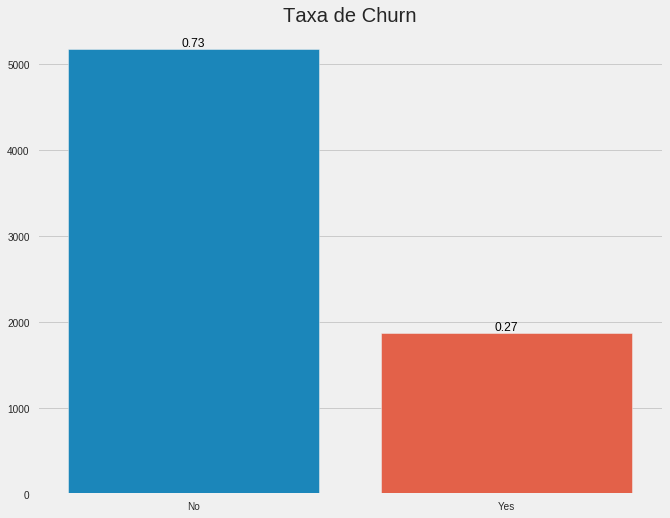

In [9]:
# Cria o novo gráfico de barras da variável "Churn"
plt.figure(figsize=(10,8))
ax = sns.barplot(x=df['Churn'].value_counts().index, 
                 y=df['Churn'].value_counts().values,
                 data=df)

total = float(len(df))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height, '{:1.2f}'.format(height/total), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.title('Taxa de Churn')
plt.show()

O gráfico mostra que grande parte dos clientes da empresa não cancelaram o contrato, cerca de **73%**. É um bom resultado para a empresa, no entanto, para o nosso modelo é algo para ser corrigindo, pois a variável esta desbalanceada. Vamos corrigir isso mais adiante, agora vamos dar continuidade a analise exploratória e limpeza das demais variáveis.

In [10]:
# Resumo dos atributos categóricos
for i in df.select_dtypes(include='category'):
    print('Variavel: ' + (i), '\n', df[i].value_counts())

Variavel: gender 
 Male      3555
Female    3488
Name: gender, dtype: int64
Variavel: SeniorCitizen 
 0    5901
1    1142
Name: SeniorCitizen, dtype: int64
Variavel: Partner 
 No     3641
Yes    3402
Name: Partner, dtype: int64
Variavel: Dependents 
 No     4933
Yes    2110
Name: Dependents, dtype: int64
Variavel: PhoneService 
 Yes    6361
No      682
Name: PhoneService, dtype: int64
Variavel: MultipleLines 
 No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Variavel: InternetService 
 Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
Variavel: OnlineSecurity 
 No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
Variavel: OnlineBackup 
 No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
Variavel: DeviceProtection 
 No                     3095
Yes     

Podemos ver que em alguns atributos categóricos possuem valores como **"No phone service"** e **"No internet service"** isso dificulta as tanto nas visualizações dos dados quanto nos algoritmos de aprendizado de máquina.

Ao invés de manter essas variáveis com esses valores, vamos substitui-los por **"No"** assim podemos ter os dados mais organizados e também quando as *variáveis dummies* forem criadas no dataset final possuirá uma dimensão menor.

In [11]:
# Substitui os valores "No phone service" por "No"
df['MultipleLines'].replace('No phone service', 'No', inplace=True)

# Faz a contagem dos valores
df['MultipleLines'].value_counts()

No     4072
Yes    2971
Name: MultipleLines, dtype: int64

In [12]:
# Seleciona as variáveis que possuem valores "No internet service"
internet_vars = ['OnlineSecurity','OnlineBackup', 'DeviceProtection', 
                 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Substitui os valores "No internet service" por "No"
for col in internet_vars:
    df[internet_vars] = df[internet_vars].replace('No internet service', 'No')

Pronto! Agora podemos criar os gráficos das variáveis categóricas.

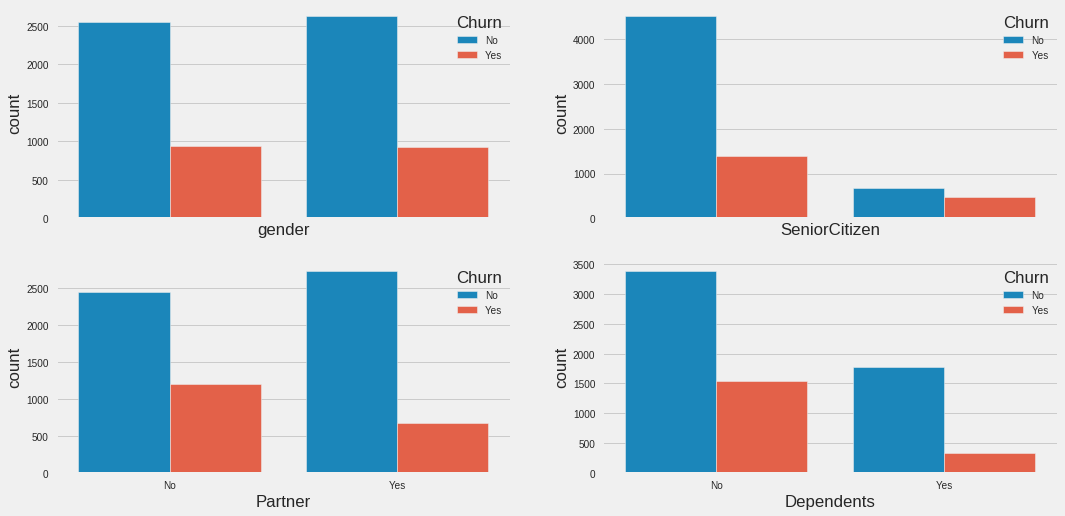

In [13]:
# Cria os subplots das variáveis categóricas
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()
cat_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

for ax, catplot in zip(axes, df[cat_vars]):
    sns.countplot(x=catplot, ax=ax, data=df, hue='Churn')

plt.show()

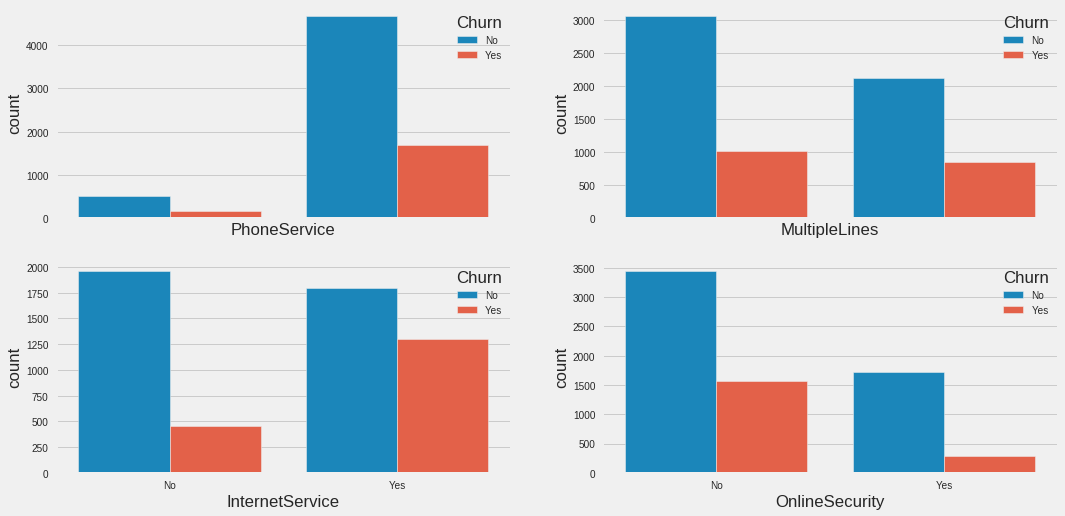

In [14]:
# Cria os subplots das variáveis categóricas
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()
cat_vars = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity']

for ax, catplot in zip(axes, df[cat_vars]):
    sns.countplot(x=catplot, ax=ax, data=df, hue='Churn')

plt.show()

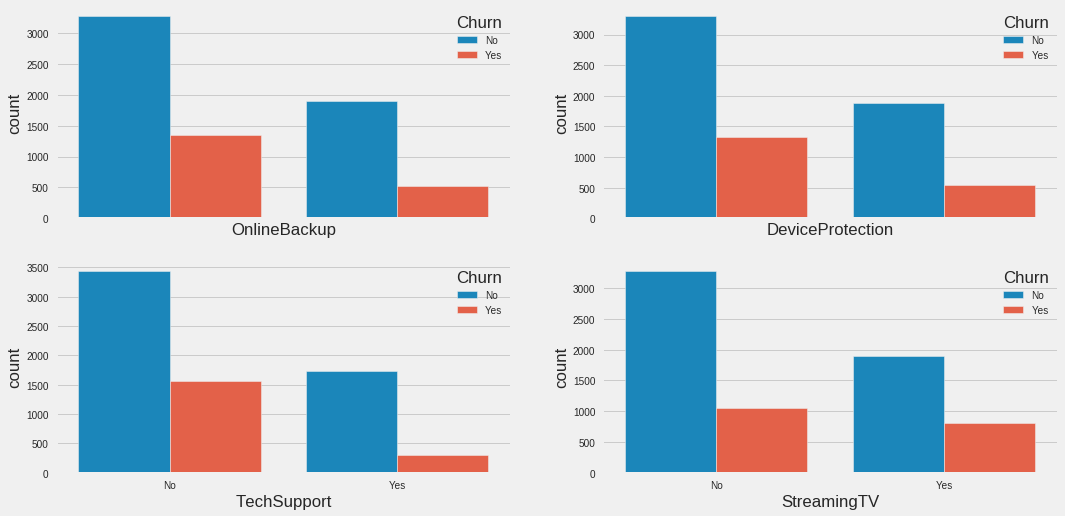

In [15]:
# Cria os subplots das variáveis categóricas
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()
cat_vars = ['OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV']

for ax, catplot in zip(axes, df[cat_vars]):
    sns.countplot(x=catplot, ax=ax, data=df, hue='Churn')

plt.show()

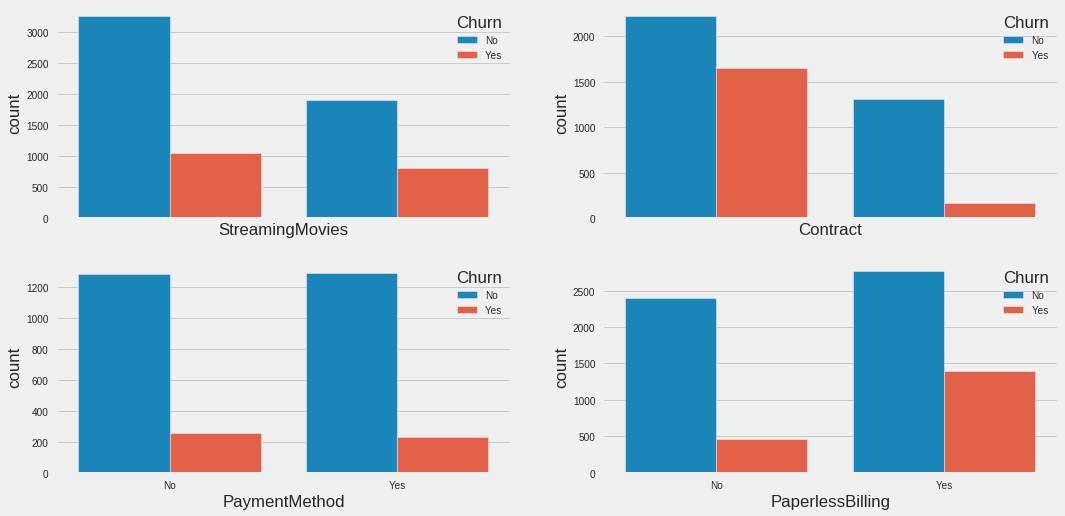

In [16]:
# Cria os subplots das variáveis categóricas
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()
cat_vars = ['StreamingMovies', 'Contract', 'PaymentMethod', 'PaperlessBilling']

for ax, catplot in zip(axes, df[cat_vars]):
    sns.countplot(x=catplot, ax=ax, data=df, hue='Churn')

plt.show()

Agora que já podemos ver os gráficos das variáveis categóricas vamos criar as *variáveis dummies*.

In [17]:
# Mapeia a variável target "Churn", para atributos binários
df['Churn'] = df['Churn'].map({'Yes': 1, 
                               'No': 0})

# Realiza uma contagem dos valores
df['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [18]:
# Seleciona as variáveis categóricas
cat_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
            'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
            'StreamingMovies', 'Contract', 'PaymentMethod', 'PaperlessBilling']

# Cria um novo dataset contendo apenas as variáveis dummies
dummies_df = pd.get_dummies(df[cat_vars])

# Observa o novo dataset
dummies_df.head()

gender_Female  gender_Male  SeniorCitizen_0  SeniorCitizen_1  Partner_No  \
0              1            0                1                0           0   
1              0            1                1                0           1   
2              0            1                1                0           1   
3              0            1                1                0           1   
4              1            0                1                0           1   

   Partner_Yes  Dependents_No  Dependents_Yes  PhoneService_No  \
0            1              1               0                1   
1            0              1               0                0   
2            0              1               0                0   
3            0              1               0                1   
4            0              1               0                0   

   PhoneService_Yes  ...  StreamingMovies_Yes  Contract_Month-to-month  \
0                 0  ...                    0                        1   
1                 1  ...                    0                        0   
2                 1  ...                    0                        1   
3                 0  ...                    0                        0   
4                 1  ...                    0                        1   

   Contract_One year  Contract_Two year  \
0                  0                  0   
1                  1                  0   
2                  0                  0   
3                  1                  0   
4                  0                  0   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  PaperlessBilling_No  PaperlessBilling_Yes  
0                           0                    0                     1  
1                           1                    1                     0  
2                           1                    0                     1  
3                           0                    1                     0  
4                           0                    0                     1  

[5 rows x 36 columns]

Agora com a análise explorátoria dos atributos categóricos realizada e as variáveis dummies criadas vamos partir para a análise exploratória das variáveis quantitativas.

In [19]:
# Seleciona as colunas que possue atributos quantitativos
quant_col = df[['tenure', 'MonthlyCharges', 'TotalCharges']]

# Resumo estatístico das medidas de tendência central
quant_col.describe()

tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2283.300441
std      24.559481       30.090047   2265.000258
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    402.225000
50%      29.000000       70.350000   1400.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000

Com base no breve resumo estatistico criado das variáveis quantitativas podemos ver que a variável `tenure` possui valores "0". Como usaremos esta variável para poder criar outras variáveis e não existe divisão por 0, vamos substituir os valores que são iguais a zero pela sua média.

In [20]:
# Substitui valores iguais a 0 da variável "tenure" pela sua média
df['tenure'].replace(0, df['tenure'].mean(), inplace=True)

Agora podemos iniciar a segunda fase da análise exploratória, criando os gráficos dos atributos quantitativos.

<Figure size 1080x720 with 0 Axes>

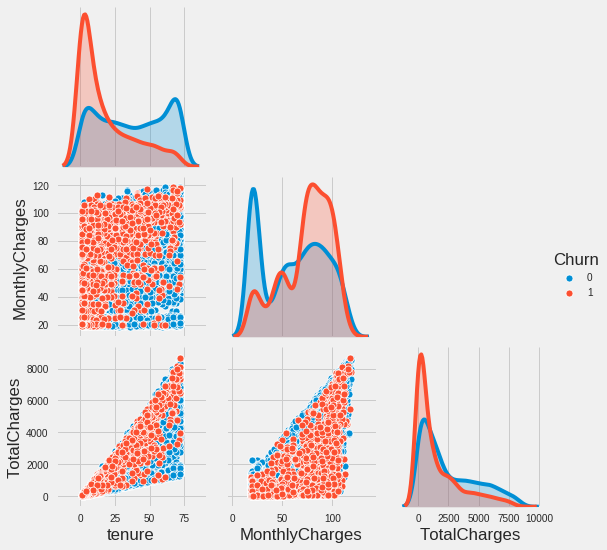

In [21]:
# Visualizando as relações entre as variáveis quantitativas através de gráfico dispersão
plt.figure(figsize=(15, 10))
sns.pairplot(df, vars=['tenure', 'MonthlyCharges', 'TotalCharges'], 
             hue='Churn', diag_kind='kde', corner=True)
plt.show()

<Figure size 1080x720 with 0 Axes>

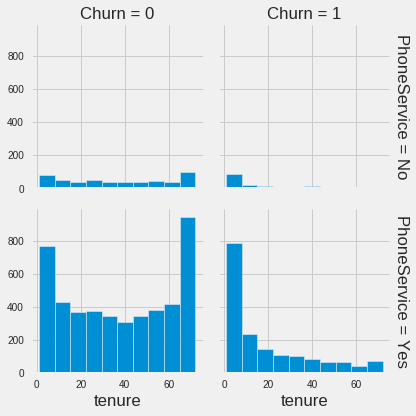

In [22]:
# Histograma da variável "ternure" dividido pelos atributos "Churn" e "PhoneService"
plt.figure(figsize=(15,10))
g = sns.FacetGrid(df, col='Churn', row='PhoneService', margin_titles=True)
g.map(plt.hist, 'tenure')
plt.show()

<Figure size 1080x720 with 0 Axes>

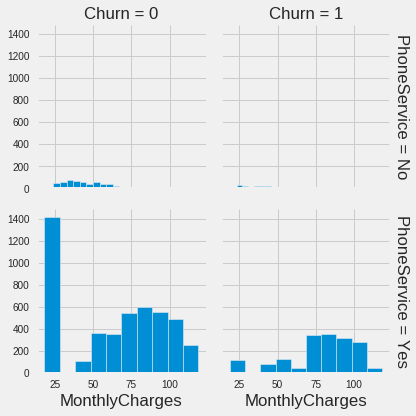

In [23]:
# Histograma da variável "MonthlyCharges" dividido pelos atributos "Churn" e "PhoneService"
plt.figure(figsize=(15,10))
g = sns.FacetGrid(df, col='Churn', row='PhoneService', margin_titles=True)
g.map(plt.hist, 'MonthlyCharges')
plt.show()

<Figure size 1080x720 with 0 Axes>

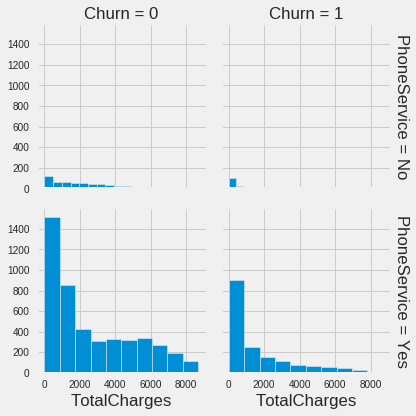

In [24]:
# Histograma da variável "TotalCharges" dividido pelos atributos "Churn" e "PhoneService"
plt.figure(figsize=(15,10))
g = sns.FacetGrid(df, col='Churn', row='PhoneService', margin_titles=True)
g.map(plt.hist, 'TotalCharges')
plt.show()

<Figure size 1080x720 with 0 Axes>

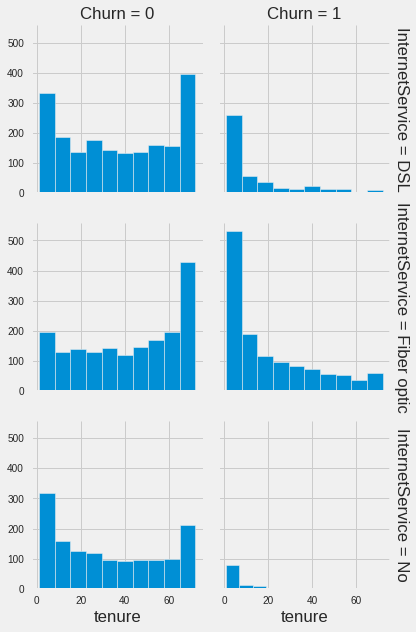

In [25]:
# Histograma da variável "ternure" dividido pelos atributos "Churn" e "InternetService"
plt.figure(figsize=(15,10))
g = sns.FacetGrid(df, col='Churn', row='InternetService', margin_titles=True)
g.map(plt.hist, 'tenure')
plt.show()

<Figure size 1080x720 with 0 Axes>

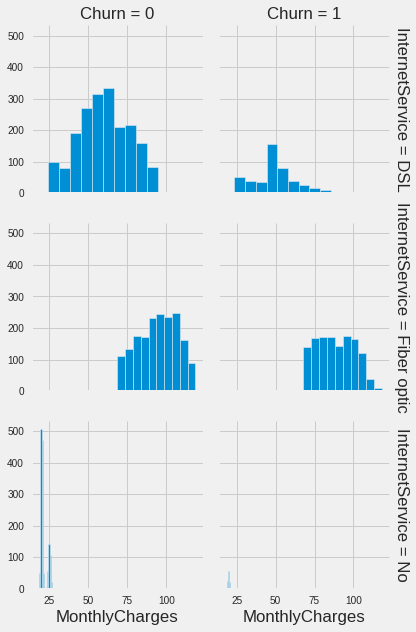

In [26]:
# Histograma da variável "MonthlyCharges" dividido pelos atributos "Churn" e "InternetService"
plt.figure(figsize=(15,10))
g = sns.FacetGrid(df, col='Churn', row='InternetService', margin_titles=True)
g.map(plt.hist, 'MonthlyCharges')
plt.show()

<Figure size 1080x720 with 0 Axes>

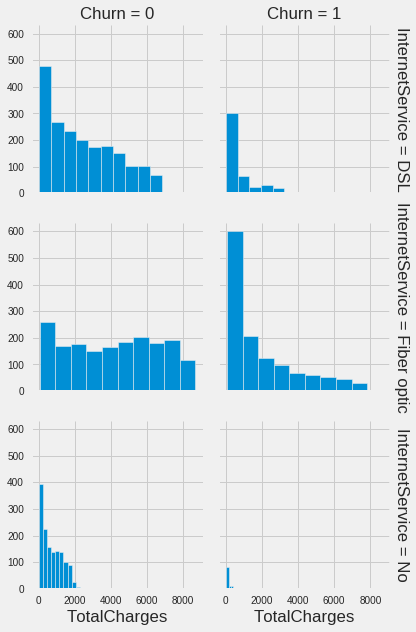

In [27]:
# Histograma da variável "TotalCharges" dividido pelos atributos "Churn" e "InternetService"
plt.figure(figsize=(15,10))
g = sns.FacetGrid(df, col='Churn', row='InternetService', margin_titles=True)
g.map(plt.hist, 'TotalCharges')
plt.show()

In [28]:
# Cria a variável "ternureMonthlyRate" - Taxa de posse mensal
df['tenureMonthlyRate'] = df['MonthlyCharges'] / df['tenure']

# Cria a variável "ternureTotalRate" - Taxa de posse total
df['tenureTotalRate'] = df['TotalCharges'] / df['tenure']

# Cria a variável "RateCharge" - Taxa de cobrança ao mês
df['RateCharge'] = df['TotalCharges'] / df['MonthlyCharges']

<Figure size 1080x720 with 0 Axes>

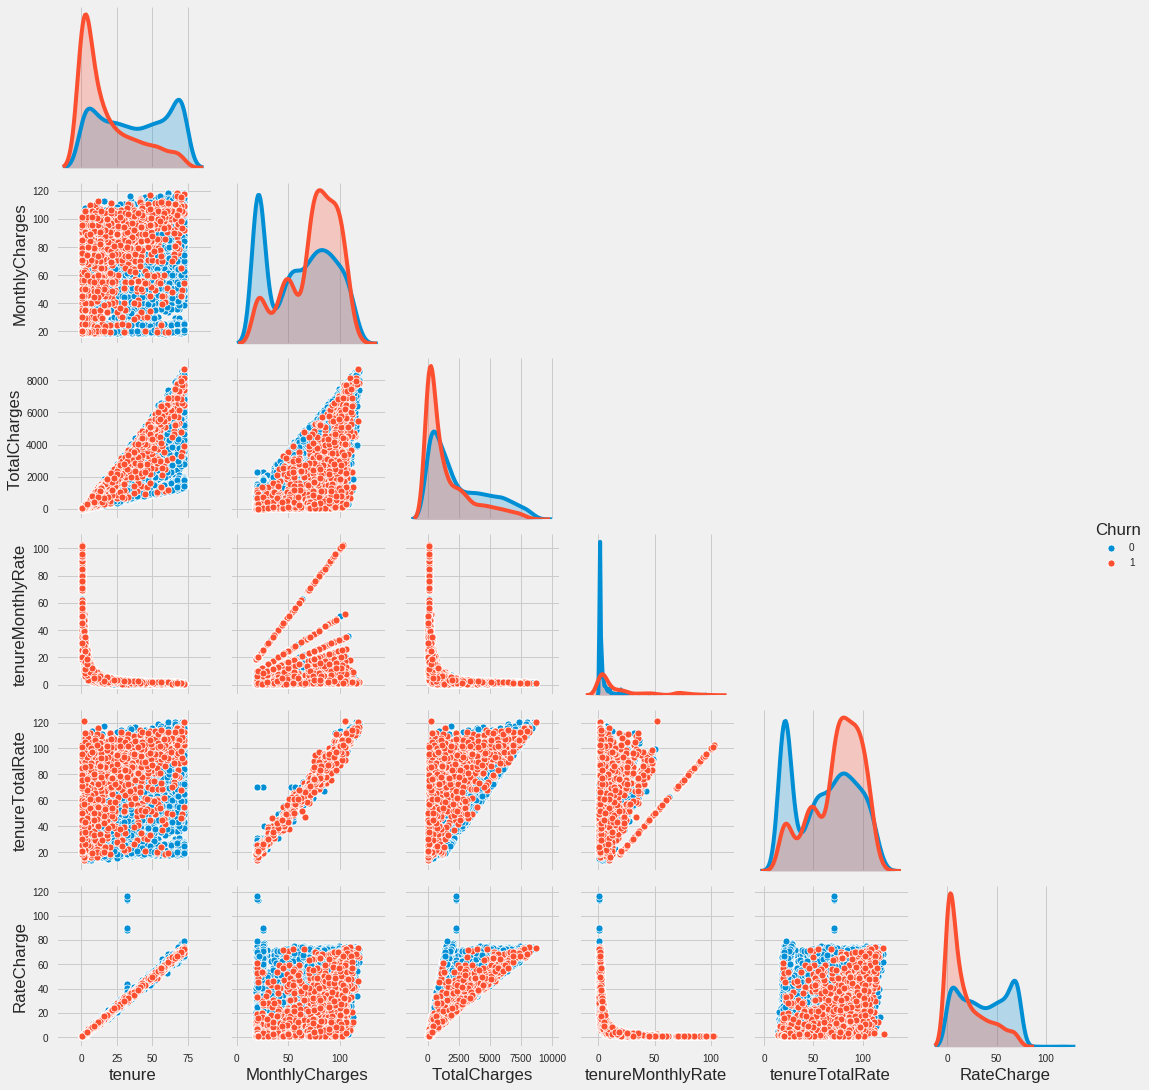

In [29]:
# Visualizando as relações entre as variáveis quantitativas através de gráfico dispersão
plt.figure(figsize=(15,10))
sns.pairplot(df, vars=['tenure', 'MonthlyCharges', 'TotalCharges', 
                      'tenureMonthlyRate', 'tenureTotalRate', 'RateCharge'], 
             hue='Churn', diag_kind='kde', corner=True)
plt.show()

Agora vamos examinar os **box-plots** das variáveis quantitativas a fim de encontrar possíveis outliers que poderão atrapalhar o algoritmo usado para poder prever o Churn

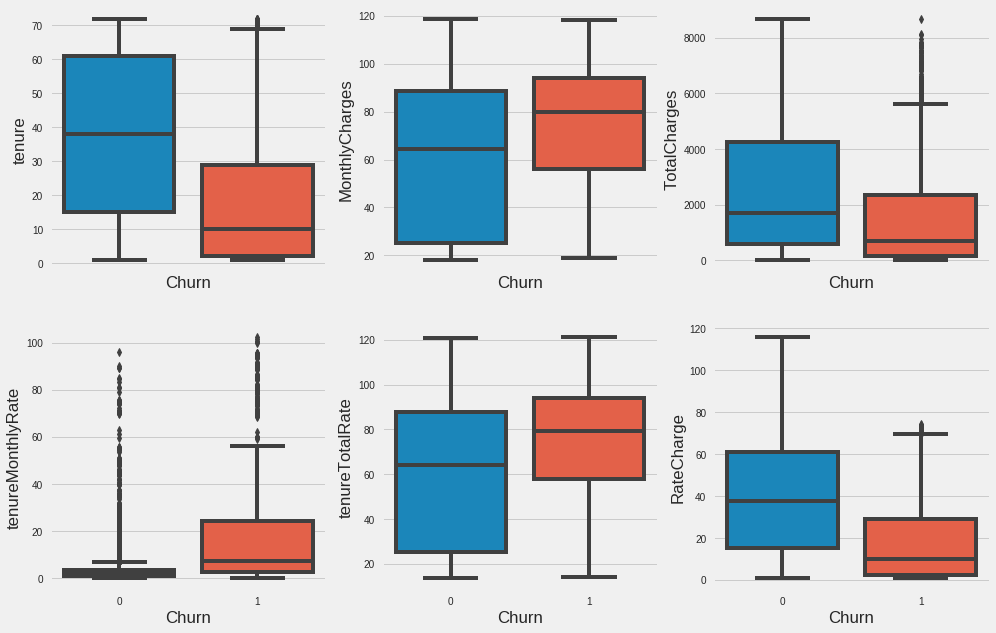

In [30]:
# Conjunto de box-plots das variáveis quantitativas
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
axes = axes.flatten()
quant_vars = ['tenure', 'MonthlyCharges', 'TotalCharges', 'tenureMonthlyRate', 'tenureTotalRate', 'RateCharge']

for ax, quantplot in zip(axes, df[quant_vars]):
    sns.boxplot(x='Churn', y=quantplot, ax=ax, data=df)

plt.show()

In [31]:
# Selecionando o 95º quantil das variáveis
upper_quantiles = df[['tenure', 'TotalCharges', 'tenureMonthlyRate', 'RateCharge']].quantile(.95)
upper_quantiles

tenure                 72.000000
TotalCharges         6921.025000
tenureMonthlyRate      45.700000
RateCharge             71.314981
Name: 0.95, dtype: float64

In [32]:
# Selecionando os dados que são maiores que o 95º quantil
outliers = (df[['tenure', 'TotalCharges', 'tenureMonthlyRate', 'RateCharge']] > upper_quantiles)

# Seleciona as colunas com outliers
outliers_vars = ['tenure', 'TotalCharges', 'tenureMonthlyRate', 'RateCharge']

# Substituindo os outliers pelo 95º quantil de cada variável
for i in outliers:
    df[outliers_vars] = df[outliers_vars].mask(outliers, upper_quantiles, axis=1)

Vamos agora ver o novo box-plot para checar se os outliers foram removidos.

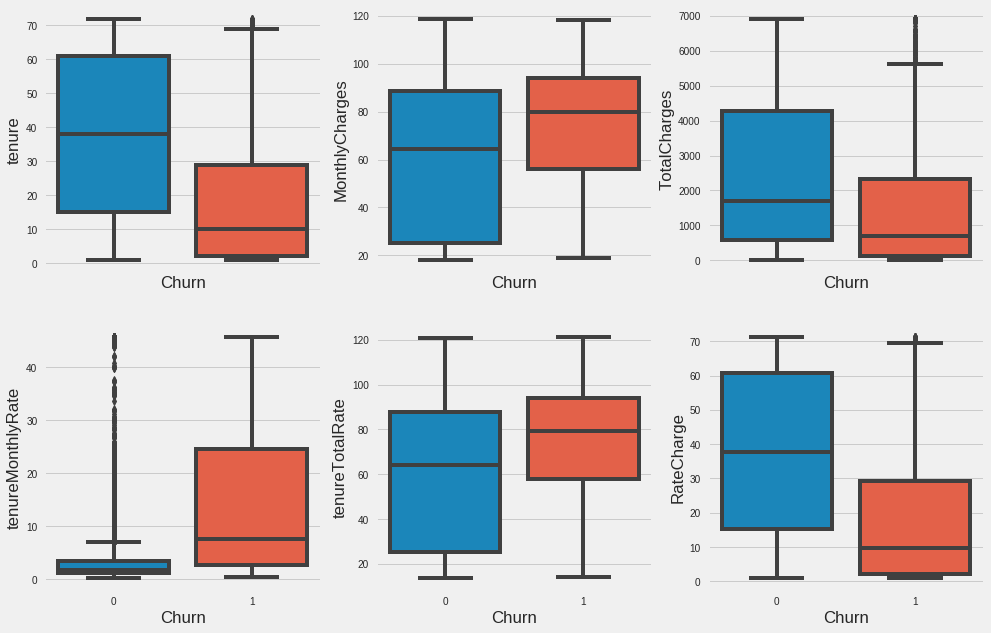

In [33]:
# Conjunto de box-plots das variáveis quantitativas com remoção de outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
axes = axes.flatten()
quant_vars = ['tenure', 'MonthlyCharges', 'TotalCharges', 'tenureMonthlyRate', 'tenureTotalRate', 'RateCharge']

for ax, quantplot in zip(axes, df[quant_vars]):
    sns.boxplot(x='Churn', y=quantplot, ax=ax, data=df)

plt.show()

Agora vamos analisar a assimetria das variáveis quantitativas, primeiro checamos essa medida e logo após plotaremos um *probplot* desses atributos para verificar se os mesmos possuem uma **distribuição normal** para que possamos aplicar os algoritmos de *machine learning*, pois este é um pré-requisito. 

In [34]:
# Assimentria das variáveis quantitativas
df[['tenure', 'MonthlyCharges', 'TotalCharges', 'tenureMonthlyRate', 'tenureTotalRate', 'RateCharge']].skew()

tenure               0.237926
MonthlyCharges      -0.220524
TotalCharges         0.855880
tenureMonthlyRate    2.284327
tenureTotalRate     -0.212157
RateCharge           0.230872
dtype: float64

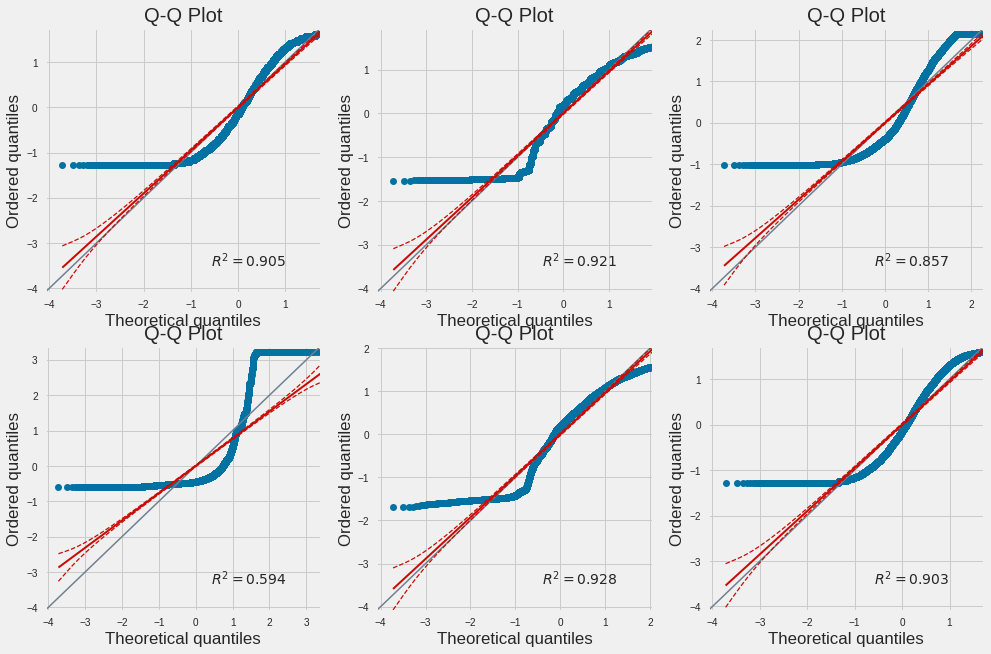

In [35]:
# Cria um Q-Q plot utilizando a biblioteca pingouin
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

ax1 = pg.qqplot(df['tenure'], dist='norm', ax=ax1)
ax2 = pg.qqplot(df['MonthlyCharges'], dist='norm', ax=ax2)
ax3 = pg.qqplot(df['TotalCharges'], dist='norm', ax=ax3)
ax4 = pg.qqplot(df['tenureMonthlyRate'], dist='norm', ax=ax4)
ax5 = pg.qqplot(df['tenureTotalRate'], dist='norm', ax=ax5)
ax6 = pg.qqplot(df['RateCharge'], dist='norm', ax=ax6)

plt.show()

Pelo gráfico é possível ver que nenhuma das variáveis seguem uma distribuição normal. Por conta disto teremos que aplicar uma transformação nessas variáveis para que as mesmas tenham distribuições normalizadas.

Para isso vamos aplicar o método **QuantileTransformer** da biblioteca Scikit Learn. Este método transforma os recursos para seguir uma distribuição uniforme ou normal. Portanto, para um determinado recurso, essa transformação tende a espalhar os valores mais frequentes e também reduzir o impacto de outliers (marginais). Esse é, portanto, um esquema robusto de pré-processamento.

In [36]:
# Intância o transformador
quantile = QuantileTransformer(random_state=42)

# Cria um novo dataset com as variáveis transformadas
df_transform = pd.DataFrame(quantile.fit_transform(df[quant_vars]), 
                            columns=['tenure', 'MonthlyCharges', 'TotalCharges',
                                     'tenureMonthlyRate', 'tenureTotalRate', 'RateCharge'])

# Nova assimétria das variáveis
df_transform.skew()

tenure              -0.036104
MonthlyCharges      -0.000050
TotalCharges        -0.016522
tenureMonthlyRate    0.022942
tenureTotalRate     -0.000031
RateCharge          -0.037274
dtype: float64

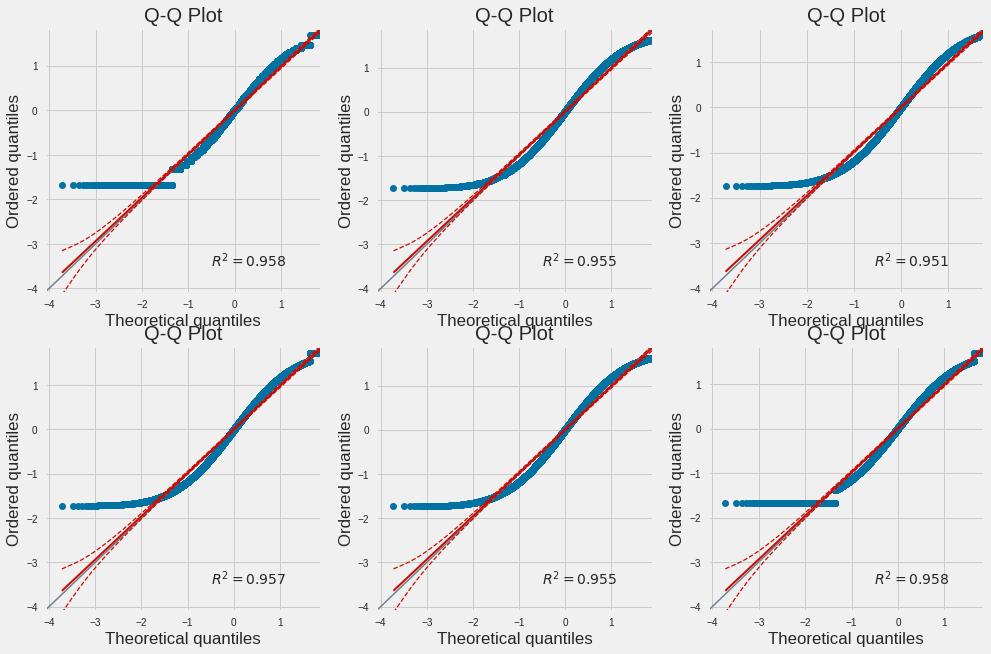

In [37]:
# Cria um Q-Q plot utilizando a biblioteca pingouin
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

ax1 = pg.qqplot(df_transform['tenure'], dist='norm', ax=ax1)
ax2 = pg.qqplot(df_transform['MonthlyCharges'], dist='norm', ax=ax2)
ax3 = pg.qqplot(df_transform['TotalCharges'], dist='norm', ax=ax3)
ax4 = pg.qqplot(df_transform['tenureMonthlyRate'], dist='norm', ax=ax4)
ax5 = pg.qqplot(df_transform['tenureTotalRate'], dist='norm', ax=ax5)
ax6 = pg.qqplot(df_transform['RateCharge'], dist='norm', ax=ax6)

plt.show()

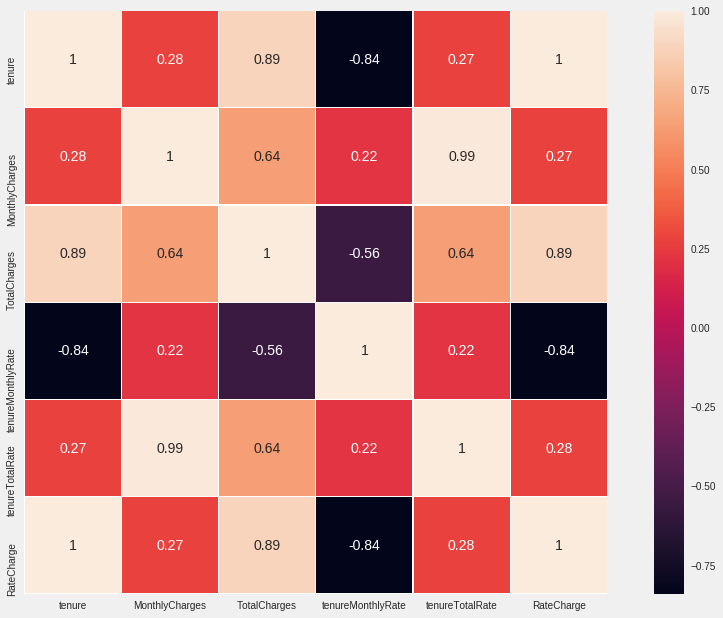

In [38]:
# Cria uma matrix de correlação dos atributos categóricos
plt.figure(figsize=(15,10))
sns.heatmap(df_transform[quant_vars].corr(method='pearson'), annot=True, linewidths=0.3, square=True)
plt.show()

Os atributos quantitativos presentes no dataset parecem ter uma correlação muito alta uns com os outros chegando alguns a possuir uma **correlação perfeita**. Isso indica que podemos ter um problema de **multicolinearidade**. 

Porém este problema pode ser contornado com a utilização de um modelo de aprendizado de máquina que seja **mais robusto** e resolva esse tipo de problema. Então, por conta desse problema usaremos o algoritmo **Light Gradient Bosting Classifier** da biblioteca **LightGBM**.

In [39]:
# Seleciona os datasets em uma lista
frames = [dummies_df, df_transform, df['Churn']]

# Concatena os mesmo pelas suas colunas
churn_df = pd.concat(frames, axis=1)

# Checa o novo dataset
churn_df.head()

gender_Female  gender_Male  SeniorCitizen_0  SeniorCitizen_1  Partner_No  \
0              1            0                1                0           0   
1              0            1                1                0           1   
2              0            1                1                0           1   
3              0            1                1                0           1   
4              1            0                1                0           1   

   Partner_Yes  Dependents_No  Dependents_Yes  PhoneService_No  \
0            1              1               0                1   
1            0              1               0                0   
2            0              1               0                0   
3            0              1               0                1   
4            0              1               0                0   

   PhoneService_Yes  ...  PaymentMethod_Mailed check  PaperlessBilling_No  \
0                 0  ...                           0                    0   
1                 1  ...                           1                    1   
2                 1  ...                           1                    0   
3                 0  ...                           0                    1   
4                 1  ...                           0                    0   

   PaperlessBilling_Yes    tenure  MonthlyCharges  TotalCharges  \
0                     1  0.000000        0.233734      0.028838   
1                     0  0.549550        0.393821      0.580681   
2                     1  0.103604        0.355063      0.119476   
3                     0  0.648649        0.268262      0.573167   
4                     1  0.103604        0.507508      0.141169   

   tenureMonthlyRate  tenureTotalRate  RateCharge  Churn  
0           0.920719         0.232746    0.000000      0  
1           0.396396         0.375107    0.542651      0  
2           0.916285         0.359611    0.105781      1  
3           0.154872         0.266029    0.635225      0  
4           0.930016         0.568214    0.113701      1  

[5 rows x 43 columns]

In [40]:
# Separa as variáveis preditoras da variável target
X = churn_df.drop('Churn', axis=1)
Y = churn_df['Churn']

# Divide o conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

Antes de treinar os modelos, resta realizar o desbalanceamento da variável alvo, `Churn`. Como existem mais clientes que não cancelaram suas contas com a empresa do que aqueles que realmente cancelaram seus planos de telefonia, existe um problema ao apresentar o atributo assim para um modelo de machine learning, pois o mesmo tendenrá a aprender mais sobre os clientes que não cancelaram do que aqueles cancelaram de fato. 

Para tanto, este problema pode ser corrigido por meio da técnica ***SMOTE*** do pacote ***imblearn***, mas antes de aplicar esta técnica de correção vamos separar o conjunto de dados em treino e teste pois o ***SMOTE*** só será aplicado nos dados de treinamento e não no conjunto de testes.

In [41]:
# Instância o método SMOTE
smote = SMOTE()

# Aplica o método nos dados de treino
X_train_balance, y_train_balance = smote.fit_sample(X_train, y_train)

# Mostra o resultado da função
print("Antes/Depois do SMOTE")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_balance, return_counts=True)
print(dict(zip(unique, counts)))

Antes/Depois do SMOTE
{0: 3892, 1: 1390}
{0: 3892, 1: 3892}


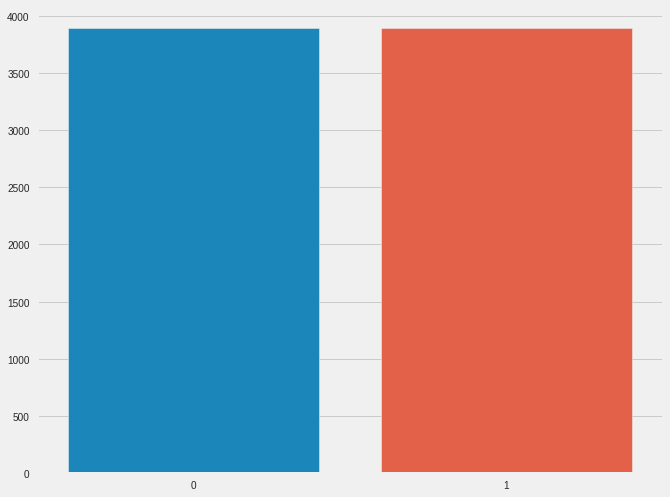

In [42]:
# Barplot da variável 'Churn' após a aplicação do SMOTE
plt.figure(figsize=(10, 8))
sns.barplot(x=y_train_balance.value_counts().index, 
            y=y_train_balance.value_counts().values)
plt.show()

Agora com tudo organizado podemos então aplicar o algoritmo *LightGBM* em nosso dataset. Pra um primeiro modelo vamos criar um modelo simples sem qualquer ajuste nos hiperparâmetros e ver se o **LGBMClassifier** é um bom algoritmo para **previsão de probabilidade de cancelamento dos clientes da Telco.**

In [43]:
# Intância o modelo
simple_LGBM = LGBMClassifier(random_state=42)

# Realiza do treinamento
simple_LGBM.fit(X_train_balance, y_train_balance)

# Realiza a previsão nos dados de teste
pred = simple_LGBM.predict(X_test)

# Salva a probabilidade prevista para cada classe em uma variável
p = simple_LGBM.predict_proba(X_test)[:, 1]

# Retorna ROCAUC para os dados de teste
print('ROCAUC Score:', (round(roc_auc_score(y_test, p), 3)))

ROCAUC Score: 0.846


Para poder ver como o modelo fez suas escolhas, vamos ver a primeira o gráfico da primeira árvore com auxílio da biblioteca **graphviz**.

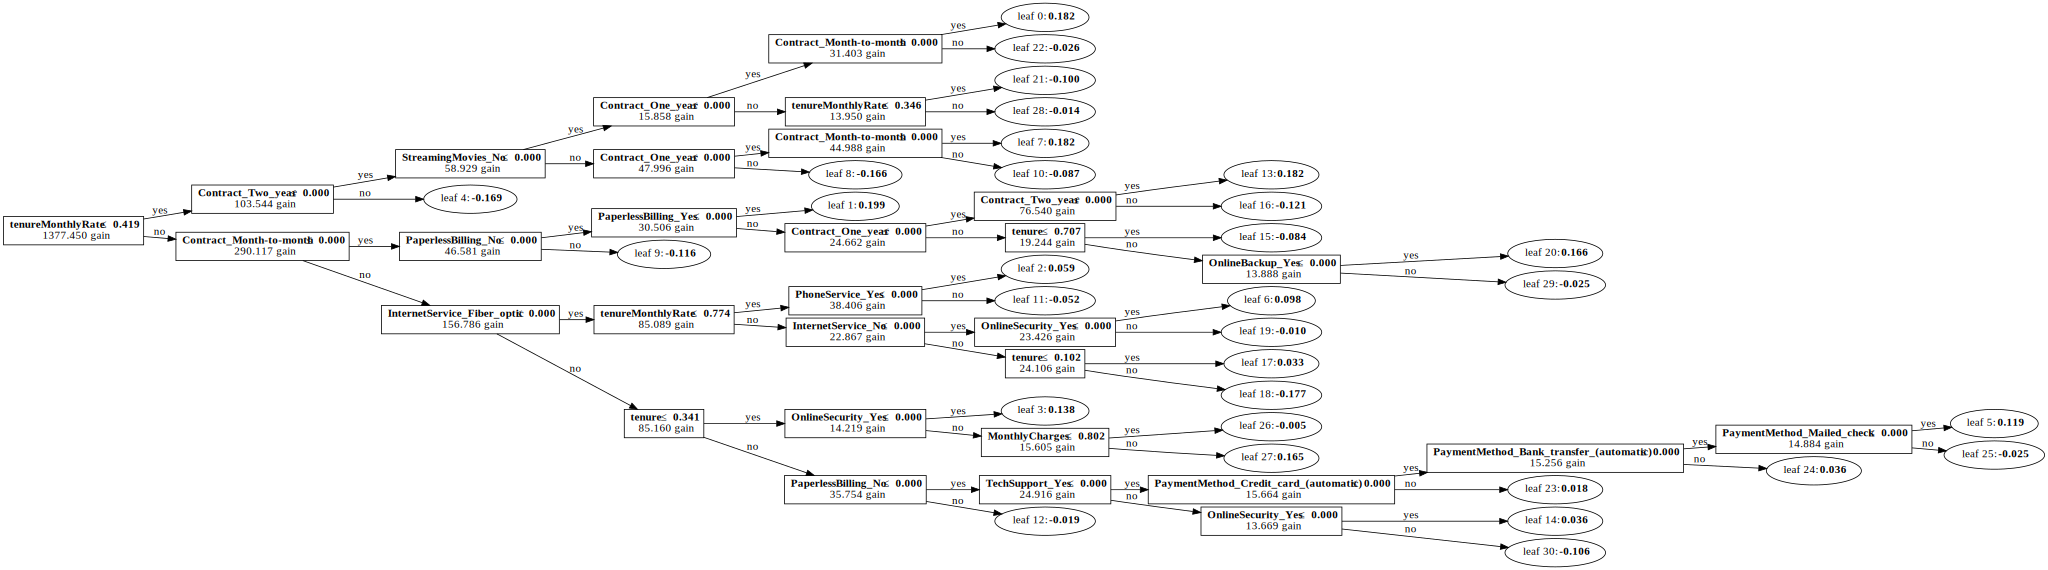

In [44]:
# Plot da primeira árvore do LightGBM
tree = create_tree_digraph(simple_LGBM, 
                           tree_index=1, 
                           show_info='split_gain')

graph = graphviz.Source(tree)
graph

Vamos ver as principais métricas de avaliação do modelo utilizando a biblioteca **Yellowbrick**, sendo elas:

* Confusion Matrix: Fornece o número de True Positive, False Positive, True Negative, False Negative;

* Classification Prediction Error: Gráfico de barras empilhado contendo os erros e acertos do modelo;

* Classification Report: Sumário contendo as metricas de classificação: Precision, Recall, f1 score e Support;

* ROC-AUC Score: ROC é uma curva de probabilidade e AUC representa grau ou medida de separabilidade. Diz quanto modelo é capaz de distinguir entre classes.

* Precision-Recall Curve: Mostra o trade-off entre precision e recall para diferentes limites. O Precision-Recall é uma medida útil do sucesso da previsão quando as classes estão muito desequilibradas. Na recuperação de informações, a precisão é uma medida da relevância dos resultados, enquanto a recuperação é uma medida de quantos resultados verdadeiramente relevantes são retornados.

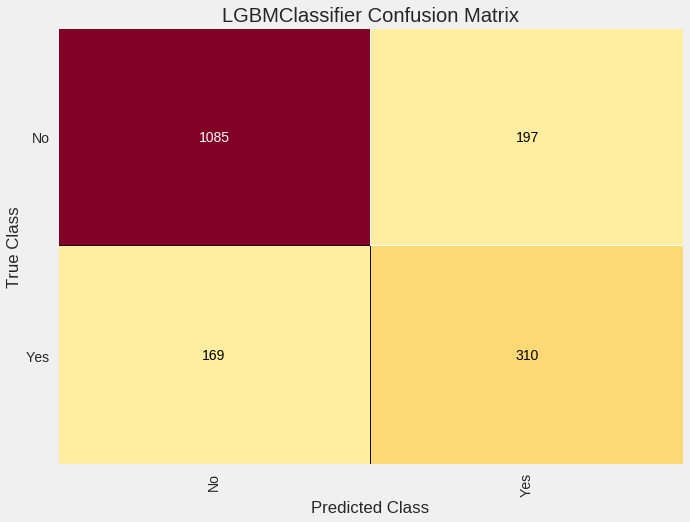

In [45]:
# Apresentando o modelo para ConfusionMatrix
conf_matrix = ConfusionMatrix(simple_LGBM, 
                              classes=['No', 'Yes'], 
                              size=(720, 540))

# Treina o modelo
conf_matrix.fit(X_train_balance, y_train_balance)

# Apresentando os dados de teste para a ConfusionMatrix
conf_matrix.score(X_test, y_test)

# Plot a Matriz de Confusão
conf_matrix.show()

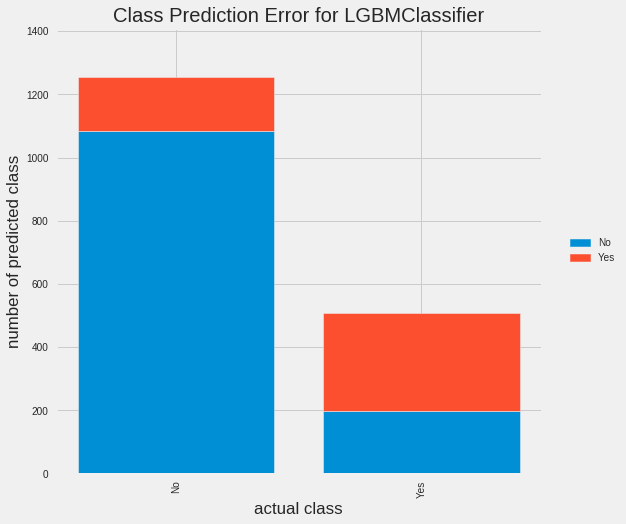

In [46]:
# Classes utilizadas pelo modelo
classes = ['Yes', 'No']

# Instantiate the classification model and visualizer
pred_error = ClassPredictionError(simple_LGBM, 
                                  classes=['No', 'Yes'], 
                                  size=(720, 540))

# Fit the training data to the visualizer
pred_error.fit(X_train_balance, y_train_balance)

# Evaluate the model on the test data
pred_error.score(X_test, y_test)

# Draw visualization
pred_error.show()

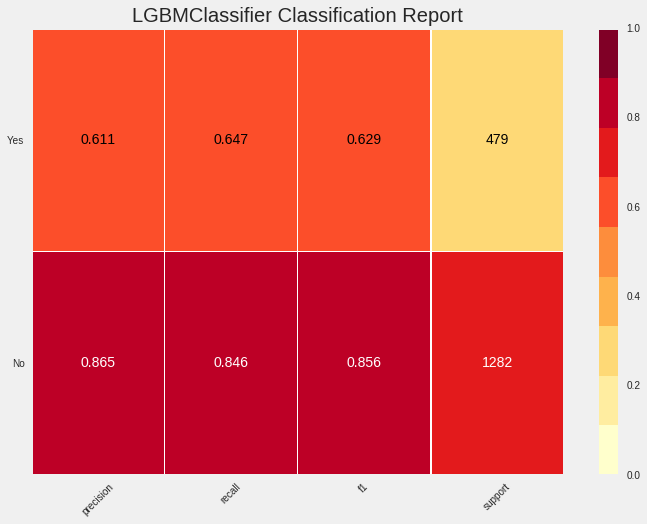

In [47]:
# Classes utilizadas pelo modelo
classes = ["No", "Yes"]

# Apresentando o modelo para ConfusionMatrix
clf_report = ClassificationReport(simple_LGBM, 
                                  classes=classes, 
                                  support=True, 
                                  size=(720, 540))

# Treina o modelo
clf_report.fit(X_train_balance, y_train_balance)

# Apresentando os dados de teste para a ClassificationReport
clf_report.score(X_test, y_test)

# Plota o Relatório de classificação
clf_report.show()

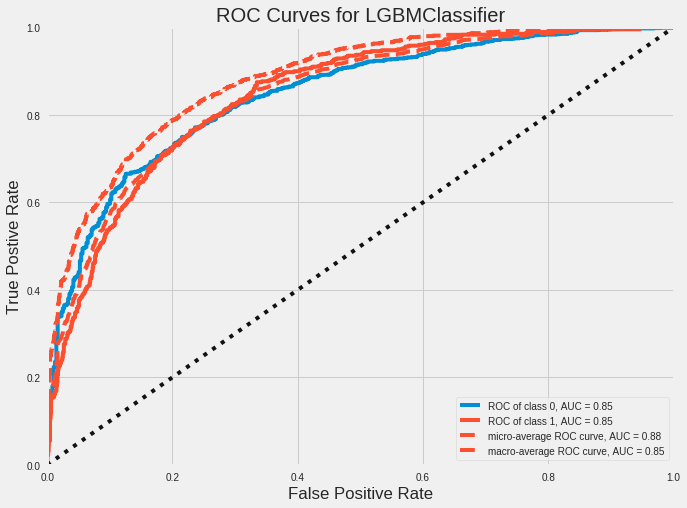

In [48]:
# Instanciando a curva ROCAUC
rocauc = ROCAUC(simple_LGBM, 
                size=(720, 540))

# Ajuste os dados de treinamento ao visualizador
rocauc.fit(X_train_balance, y_train_balance)

# Avalie o modelo nos dados de teste
rocauc.score(X_test, y_test)

# Plota da curva ROCAUC
rocauc.show()

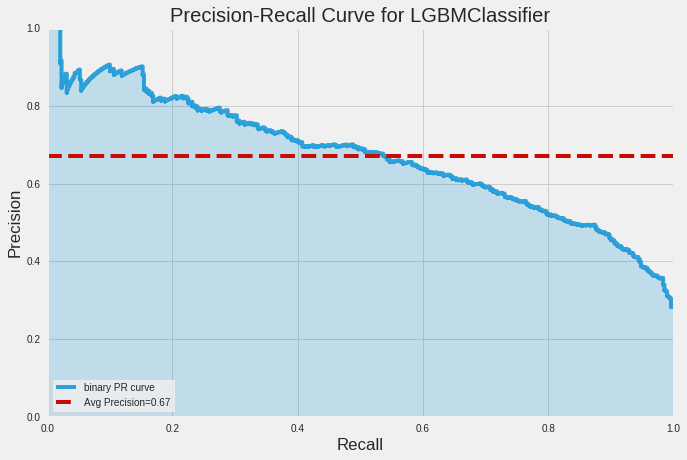

In [49]:
# Instanciando a curva de Precisão-Revocação
pr_curve = PrecisionRecallCurve(simple_LGBM, 
                                size=(720, 480))

# Ajuste os dados de treinamento ao visualizador
pr_curve.fit(X_train_balance, y_train_balance)

# Avalie o modelo nos dados de teste
pr_curve.score(X_test, y_test)

# Plota da curva Precisão-Revocação
pr_curve.show()

Para a seleção do modelo usaremos duas técnicas sendo os scores da validação cruzada e a curva de aprendizado, ambas serão explicadas a seguir. 

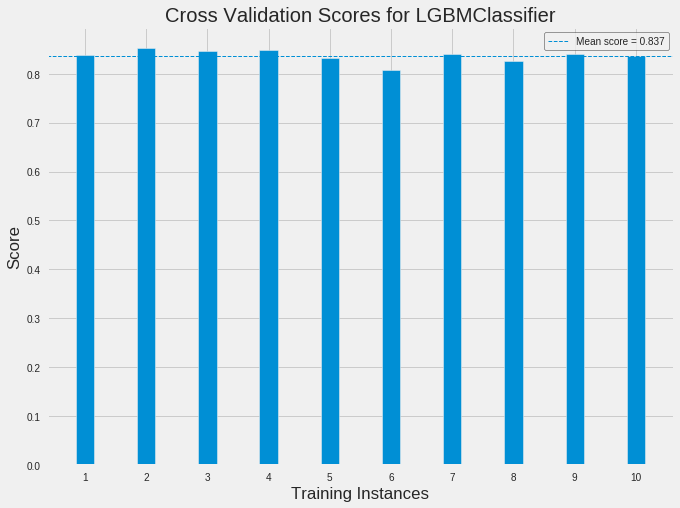

In [50]:
# Cria uma estratégia para a validação cruzada
cv = StratifiedKFold(n_splits=10, random_state=42)

# Instanciando o modelo de classificação e o visualizador
cv_viz = CVScores(simple_LGBM,
                  cv=cv, 
                  scoring='roc_auc', 
                  size=(720, 540))

# Ajuste os dados de treinamento ao visualizador
cv_viz.fit(X, Y)

# Plota os scores da validação cruzada
cv_viz.show()

Para a estratégia de validação utilizamos uma divisão **StratifiedKFold** para garantir que todas as nossas classes em cada divisão sejam representadas com a mesma proporção, Em seguida, ajustamos o CVScoresvisualizador usando a ROC-AUC score.

A visualização resultante mostra que, embora nossa pontuação média de validação cruzada seja alta **84%**, há algumas divisões para as quais o Light Gradient Bosting **sem qualquer ajuste** tem um desempenho significativamente menor.

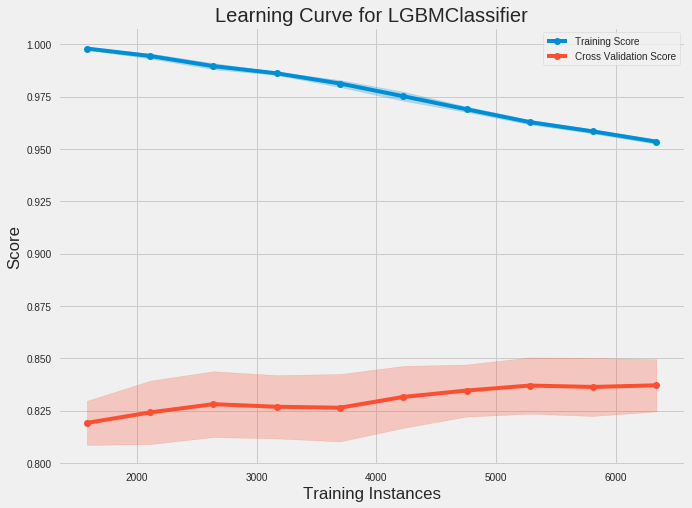

In [51]:
# Cria a divisão dos dados
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.25, 1.0, 10)

# Instanciando o modelo de classificação e o visualizador
visualizer = LearningCurve(simple_LGBM, 
                           cv=cv, 
                           scoring='roc_auc', 
                           train_sizes=sizes, 
                           n_jobs=4, 
                           size=(720, 540))

# Ajuste os dados de treinamento ao visualizador
visualizer.fit(X, Y)

# Plota os scores da validação cruzada
visualizer.show()

Uma curva de aprendizado mostra a relação da pontuação do treinamento versus a pontuação do teste da validação cruzada para um estimador com um número variável de amostras de treinamento. 

Se as pontuações de treinamento e validação cruzada convergirem à medida que mais dados forem adicionados, o modelo provavelmente não se beneficiará de mais dados. Se a pontuação do treinamento for muito maior que a pontuação da validação, o modelo provavelmente precisará de mais exemplos de treinamento para generalizar com mais eficiência.

Em nossa curva de aprendizado mostra pouca variabilidade, o modelo começa a **convergir** para um ROC-AUC score de cerca de **0,85**. Podemos ver que as pontuações de treinamento e teste ainda não convergiram, portanto, potencialmente, esse modelo se beneficiaria com mais dados de treinamento.

Já podemos perceber que o nosso modelo sem qualquer ajuste tem bons resultados, porém, podemos melhora-lo através de **tunning dos seus hiperparâmetros**. Como o LightGBM possui muitos hiperparâmetros o **GridSearch** se torna impraticavel, então para realizar o tunning vamos utilizar **Otimização Bayessiana usando Processos Gaussianos**.

Como o LightGBM é uma função de **caixa preta**, sem forma fechada nem gradientes, a idéia é **aproximar a função usando um processo gaussiano**. Em outras palavras, supõe-se que os valores das funções sigam um processo gaussiano multivariado. A covariância dos valores das funções é dada por um kernel GP entre os parâmetros. 

Em seguida, uma escolha inteligente para escolher o próximo parâmetro a ser avaliado pode ser feita pela função de aquisição a priori gaussiano, que é muito mais rápida de avaliar.

In [52]:
# Define a função
def train_model(params):
    
    # Hiperparâmetros utilizados
    learning_rate = params[0] # Taxa de aprendizado
    num_leaves = params[1] # Número de folhas por árvore
    min_child_samples = params[2] # Número de amostras por folhas
    subsample = params[3] # Proporção de subamostra da instância de treinamento
    colsample_bytree = params[4] # Proporção de subamostra de colunas ao construir cada árvore
    n_estimators = params[5] # Número de árvores
    reg_alpha = params[6] # Regularização L1
    reg_lambda = params[7] # Regularização L2
    
    # Parâmetros a cada rodada
    print(params, '\n')
    
    # Classificador com os hiperparâmetros
    LGBM_opt = LGBMClassifier(learning_rate=learning_rate, 
                              num_leaves=num_leaves, 
                              min_child_samples=min_child_samples, 
                              subsample=subsample, 
                              colsample_bytree=colsample_bytree,
                              n_estimators=n_estimators,
                              reg_alpha = reg_alpha,
                              reg_lambda = reg_lambda,
                              subsample_freq=1,
                              random_state=42)
    
    # Realiza o treinamento do modelo
    LGBM_opt.fit(X_train_balance, y_train_balance)
    
    # Salva a probabilidade prevista para cada classe em uma variável
    prob = LGBM_opt.predict_proba(X_test)[:, 1]
    
    # Score do modelo
    return -roc_auc_score(y_test, prob)

# Espaços dos hiperparâmetros utilizados
space = [(1e-5, 1e-1, 'log-uniform'), # learning_rate
         (2, 256), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0), # colsample_bytree
         (100, 1000), # n_estimators
         (0.1, 10),  # reg_alpha
         (0.1, 10)] # reg_lambda

In [53]:
# Otimização Bayesssiana poor Processos Gausssianos 
result_gp = gp_minimize(train_model, # Função a ser minimizada
                        space, # Espaços dos hiperparâmetros a ser otimizado
                        n_calls=50, # Número de rodadas para otimização
                        n_random_starts=10, # Número de avaliações de pontos aleatórios antes de aproximar a função.
                        random_state=42, 
                        verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.01535224694197351, 49, 78, 0.6170076500491628, 0.5012494775682321, 190, 4.646564030462086, 3.403715250276317] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4041
Function value obtained: -0.8600
Current minimum: -0.8600
Iteration No: 2 started. Evaluating function at random point.
[3.727925903376984e-05, 167, 7, 0.7358988336534836, 0.9446974381141754, 101, 9.922894436983055, 6.213066945314394] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3609
Function value obtained: -0.8537
Current minimum: -0.8600
Iteration No: 3 started. Evaluating function at random point.
[0.0027964859516062465, 4, 3, 0.5485359272454697, 0.45987487454373, 142, 9.740179636530447, 2.4044362702600126] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1604
Function value obtained: -0.8502
Current minimum: -0.8600
Iteration No: 4 started. Evaluating function at random point.
[2.3036

Agora que a otimização já foi feita vamos ver os parâmetros escolhidos durante o processo que maximiza nosso ROC-AUC score.

In [54]:
# Hiperparâmetros escolhidos durante a otimização
print('Melhores parâmetros para maximização do ROC-AUC score: ', result_gp.x)

Melhores parâmetros para maximização do ROC-AUC score:  [0.040040602891705274, 227, 95, 0.12451040991733231, 0.9891883695231313, 355, 0.32377227705710576, 9.828480972349379]


Vamos visualizar o caminho percorrido durante a busca feita pelo Processo Gaussiano até a convergência dos melhores hiperparâmetros do modelo.

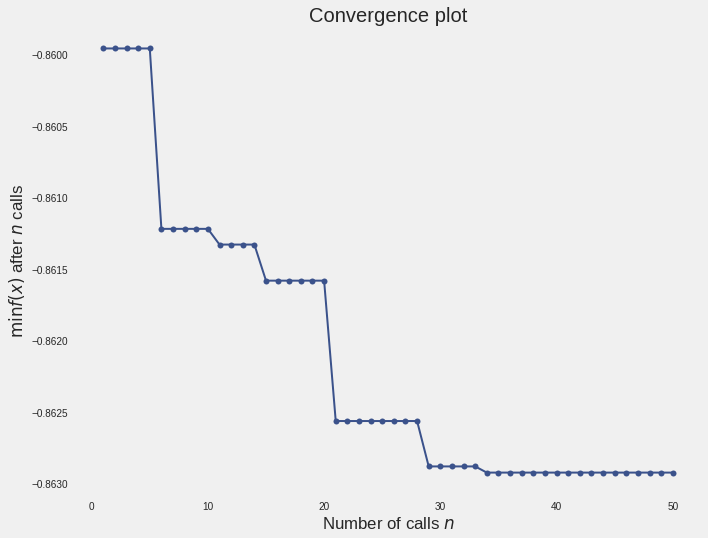

In [55]:
# Plot da convergência do Processo Gaussiano.
plt.figure(figsize=(10, 8))
plot_convergence(result_gp)

Agora que possuimos o modelo com os melhores hiperparâmetros, aqueles **maximizam o ROC-AUC Score** vamos realizar o treino e teste para poder compara-lo com o modelo anterior.  

In [56]:
# Instancia o modelo Light Gradient Bosting Classifier
LGBM_clf = LGBMClassifier(learning_rate=0.03855, 
                          num_leaves=252, 
                          min_child_samples=99, 
                          subsample=0.08280, 
                          colsample_bytree=0.11390,
                          n_estimators=286,
                          reg_alpha = 0.31956,
                          reg_lambda = 1.22231,
                          subsample_freq=1,
                          random_state=42)

# Treinando o modelo e aplicando o Cross Validation
LGBM_clf.fit(X_train_balance, y_train_balance)

# Salva a probabilidade prevista para cada classe em uma variável 
prob = LGBM_clf.predict_proba(X_test)[:,1]

De ínicio vamos checar como ficou a primeira árvore do LightGBM.

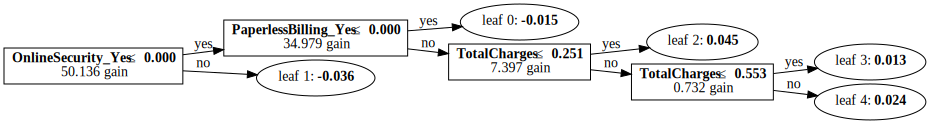

In [57]:
# Plot do modelo de árvore final do LightGBM
tree = create_tree_digraph(LGBM_clf, 
                           tree_index=1, 
                           show_info='split_gain')

graph = graphviz.Source(tree)
graph

Pela imagem acima podemos ver que o modelo com os hiperparâmetros otimizados possuem árvores menores do que sem o tuning de hiperparâmetros. Isso geralmente se deve ao fato dos valores escolhidos para as reguralizações de **L1** e **L2** do modelo, isso torna a escolha pelos preditores mais simplificada e geralmente mais acertiva.

Agora vamos examinar os principais atributos do modelo pelo método **plot_importance** do LightGBM. Esse não é um bom critério para escolhas das features e nem será usado para realizar a escolha das mesmas, porém, servirá para um comparação futura que será feita a seguir.

Pelo gráfico podemos ver que as variáveis quantitativas são as que possuem maior importancia para explicação das escolhas da taxa de cancelamento.

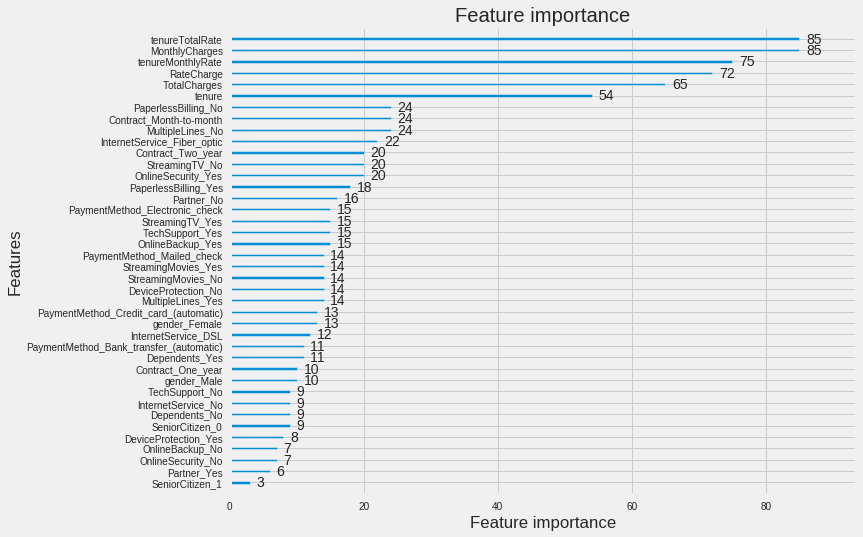

In [58]:
# Features mais importantes no modelo
features_imp = plot_importance(LGBM_clf, 
                               importance_type='split', 
                               figsize=(10, 8))

As metricas anteriormente apresentadas como: Confusion Matrix, ROC-AUC Curve e Precision-Recall Curve todas possuem melhores scores do que visto no primeiro modelo. Os resultados podem ser vistos abaixo em seus respectivos gráficos que foram criados por meio da biblioteca yellowbrick.

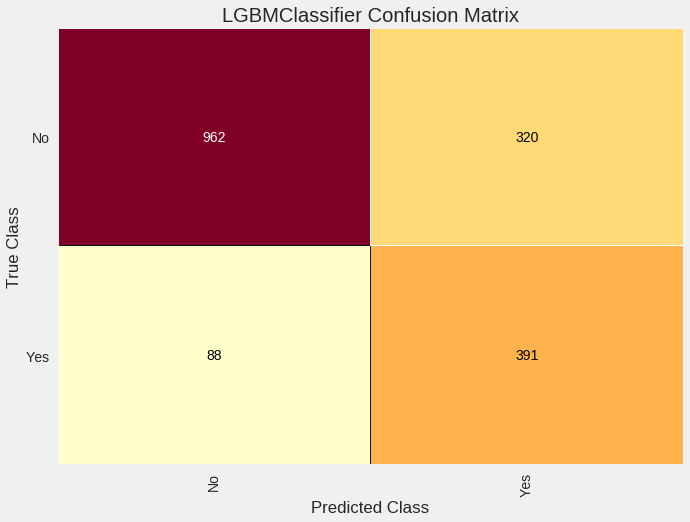

In [59]:
# Apresentando o modelo para ConfusionMatrix
conf_matrix = ConfusionMatrix(LGBM_clf, 
                              classes=['No', 'Yes'], 
                              size=(720, 540))

# Treina o modelo
conf_matrix.fit(X_train_balance, y_train_balance)

# Apresentando os dados de teste para a ConfusionMatrix
conf_matrix.score(X_test, y_test)

# Plot a Matriz de Confusão
conf_matrix.show()

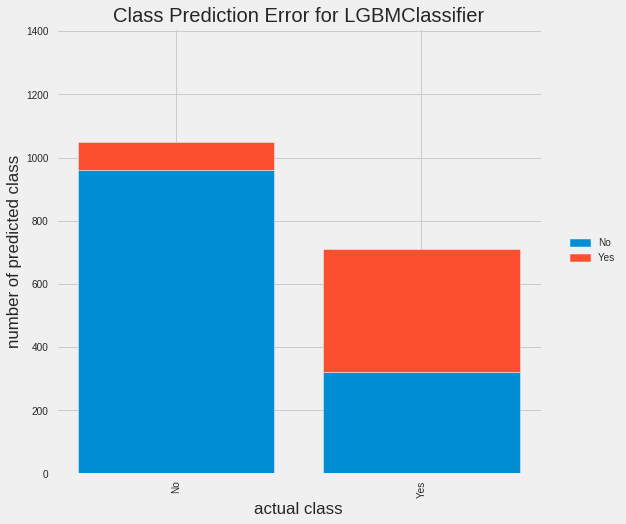

In [60]:
# Classes utilizadas pelo modelo
classes = ['Yes', 'No']

# Instantiate the classification model and visualizer
pred_error = ClassPredictionError(LGBM_clf, 
                                  classes=['No', 'Yes'], 
                                  size=(720, 540))

# Fit the training data to the visualizer
pred_error.fit(X_train_balance, y_train_balance)

# Evaluate the model on the test data
pred_error.score(X_test, y_test)

# Draw visualization
pred_error.show()

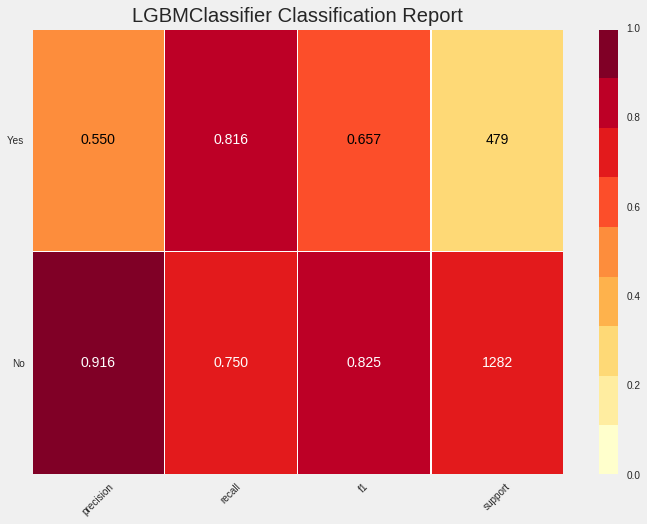

In [61]:
# Classes utilizadas pelo modelo
classes = ["No", "Yes"]

# Apresentando o modelo para ConfusionMatrix
clf_report = ClassificationReport(LGBM_clf, 
                                  classes=classes, 
                                  support=True, 
                                  size=(720, 540))

# Treina o modelo
clf_report.fit(X_train_balance, y_train_balance)

# Apresentando os dados de teste para a ClassificationReport
clf_report.score(X_test, y_test)

# Plota o Relatório de classificação
clf_report.show()

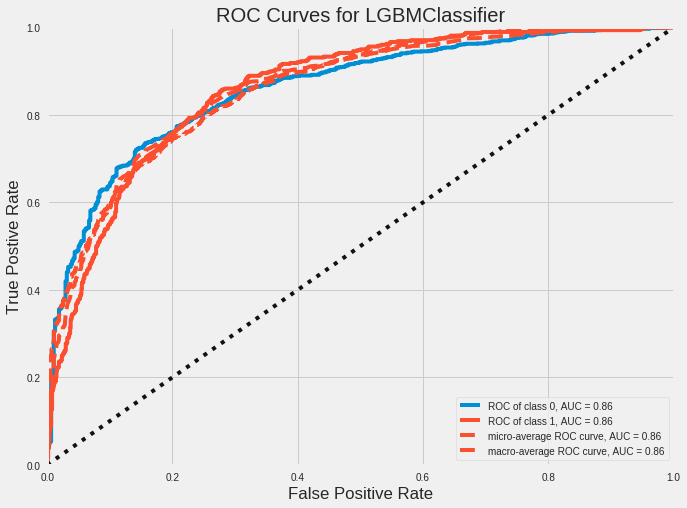

In [62]:
# Instanciando a curva ROCAUC
rocauc = ROCAUC(LGBM_clf, 
                size=(720, 540))

# Ajuste os dados de treinamento ao visualizador
rocauc.fit(X_train_balance, y_train_balance)

# Avalie o modelo nos dados de teste
rocauc.score(X_test, y_test)

# Plota da curva ROCAUC
rocauc.show()

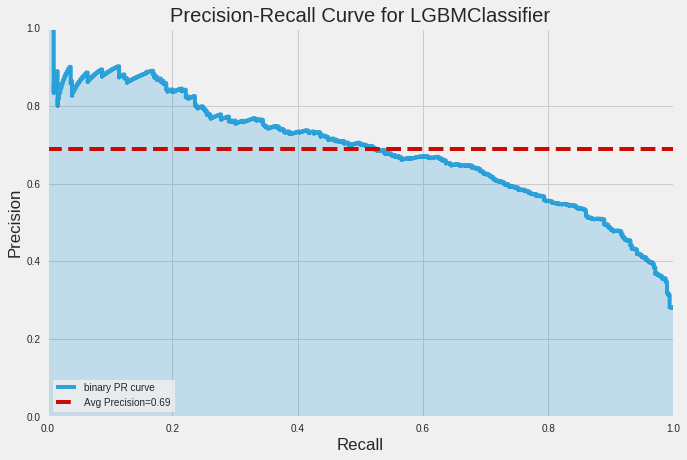

In [63]:
# Instanciando a curva de Precisão-Revocação
pr_curve = PrecisionRecallCurve(LGBM_clf, 
                                size=(720, 480))

# Ajuste os dados de treinamento ao visualizador
pr_curve.fit(X_train_balance, y_train_balance)

# Avalie o modelo nos dados de teste
pr_curve.score(X_test, y_test)

# Plota da curva Precisão-Revocação
pr_curve.show()

Os scores para a validação cruzada ficaram práticamente iguais as do primeiro modelo. Enquanto a curva de aprendizado se mostra completamente diferente, podemos enxergar a conversão das curvas de treino e validação e eliminação do viés encotrado no primeiro modelo, porém a curva ainda indica que com mais dados podemos melhorar a performace do modelo.

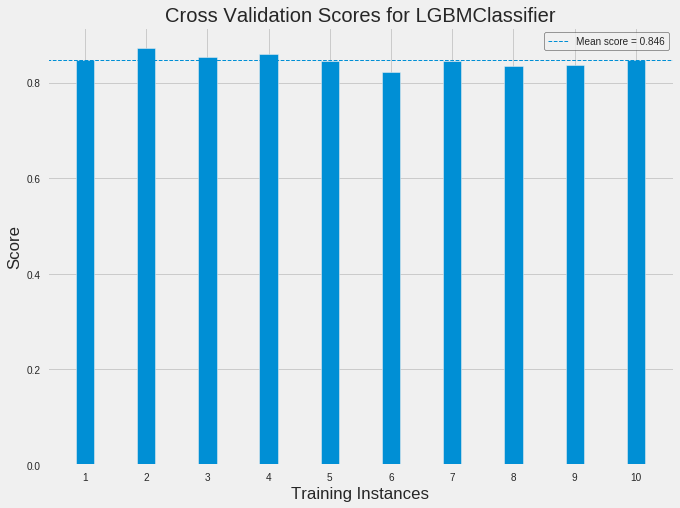

In [64]:
# Cria uma estratégia para a validação cruzada
cv = StratifiedKFold(n_splits=10, random_state=42)

# Instanciando o modelo de classificação e o visualizador
cv_viz = CVScores(LGBM_clf,
                  cv=cv, 
                  scoring='roc_auc', 
                  size=(720, 540))

# Ajuste os dados de treinamento ao visualizador
cv_viz.fit(X, Y)

# Plota os scores da validação cruzada
cv_viz.show()

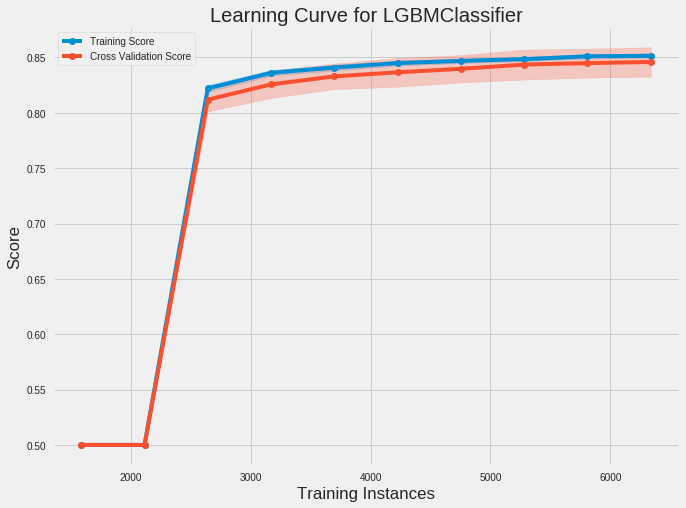

In [65]:
# Cria a divisão dos dados
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.25, 1.0, 10)

# Instanciando o modelo de classificação e o visualizador
visualizer = LearningCurve(LGBM_clf, 
                           cv=cv, 
                           scoring='roc_auc', 
                           train_sizes=sizes, 
                           n_jobs=4, 
                           size=(720, 540))

# Ajuste os dados de treinamento ao visualizador
visualizer.fit(X, Y)

# Plota os scores da validação cruzada
visualizer.show()

Agora que visualizamos os scores do modelo já otimizado vamos tentar descobri as possíveis explicações para as saídas do modelo.

Como o modelo Light Gradient Boosting se trata de um modelo **"Black Box"** vamos utilizar Shapley Values para que possamos explicar as contribuições marginais de cada uma das variáveis para contribuição final da saída do modelo. Para fazer isso vamos utilizar a biblioteca **Shap**. 

SHAP (SHapley Additive exPlanations) é uma abordagem teórica do jogo para explicar a saída de qualquer modelo de aprendizado de máquina. Ele conecta a alocação de crédito ideal com explicações locais, usando os valores clássicos de Shapley da teoria dos jogos e suas extensões relacionadas.

In [66]:
# Imprima o código de visualização JS no notebook
shap.initjs()

# Aplica o método TreeExplaneir no LightGBM
explainer = shap.TreeExplainer(LGBM_clf)

# Obtém os valores de SHAP pra as variáveis do modelo 
shap_values = explainer.shap_values(X)

Com o método **summary_plot** usamos os valores SHAP para identificar quanto impacto cada recurso tem na saída do modelo. Os recursos são classificados pela soma das magnitudes do valor SHAP em todas as amostras. É interessante notar que o atributo `tenureMonthyRate` tem mais impacto total do modelo do que o atributo `tenureTotalRate` como mostrado pelo método **plot_importances** do pacote **LightGBM**.

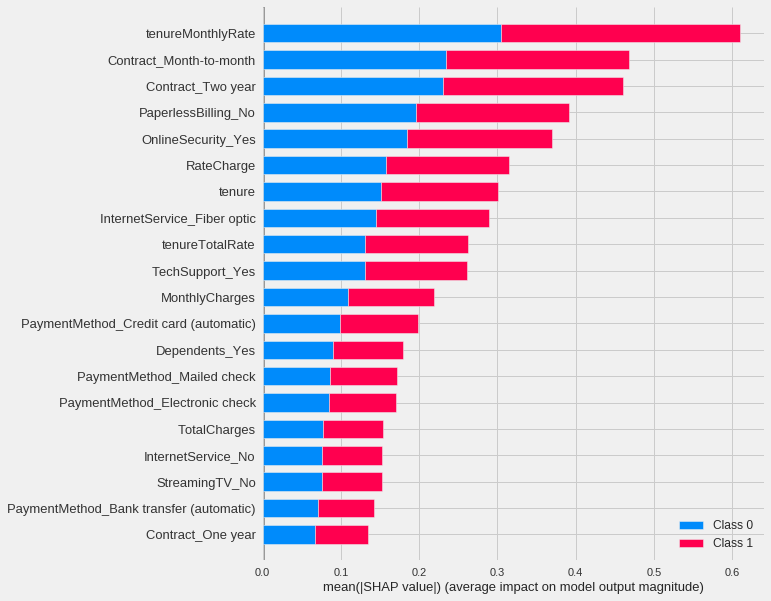

In [67]:
# Resumo das contribuições de cada variável para a saída do modelo
shap.summary_plot(shap_values, X)

Em contraste com o primeiro o gráfico para explicar o impacto marginal dos recursos na saída final do modelo **summary_plot** possui uma versão estendida. Este gráfico de resumo substitui o gráfico de barras típico da importância do recurso. Além de informar quais são as variáveis mais importantes para saída final do modelos, também informam uma gama de efeitos sobre o conjunto de dados. A cor nos permite comparar como as mudanças no valor de um recurso afetam a rotatividade dos clientes.

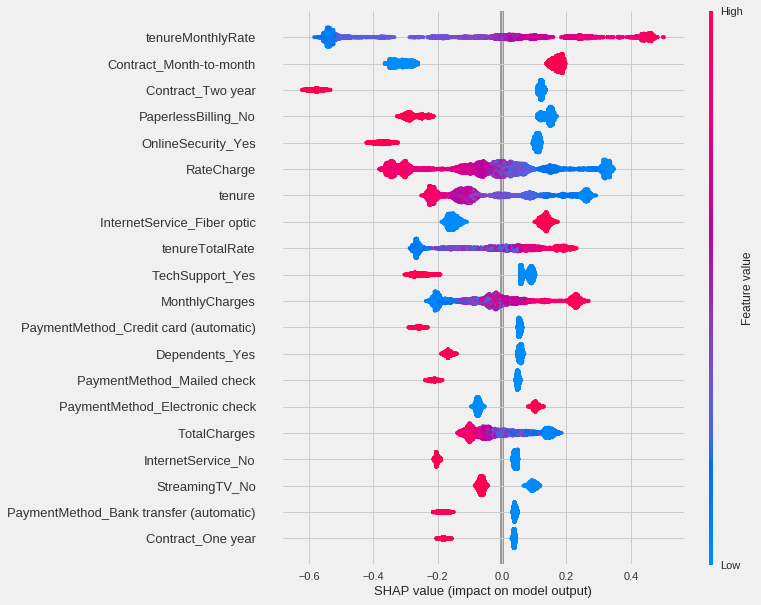

In [68]:
# Resumo estendido das contribuições de cada variável para a saída do modelo
shap.summary_plot(shap_values[1], X)

Os gráficos de dependência do SHAP mostram o efeito de um único recurso em todo o conjunto de dados. O gráfico de dependência parcial mostra o efeito marginal que uma ou duas características têm sobre o resultado previsto de um modelo de aprendizado de máquina.

A dispersão vertical dos valores SHAP em um único valor de recurso é impulsionada por efeitos de interação, e outro recurso é escolhido para colorir para destacar possíveis interações. A função inclui automaticamente outra variável com a qual sua variável escolhida interage mais. 

A seguir veremos os primeiros **dependence_plot** das **cinco principais variáveis do modelo**, sendo que o gráfico a seguir mostra que há uma tendência positiva porém um pouco complexa entre a interação entre`tenureMonthlyRate` e a variável `tenure`, para explicar o cancelamento ou não pelo cliente.

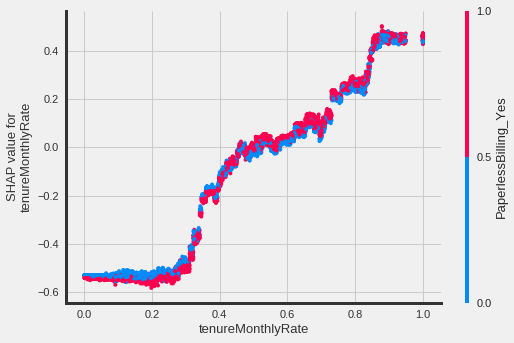

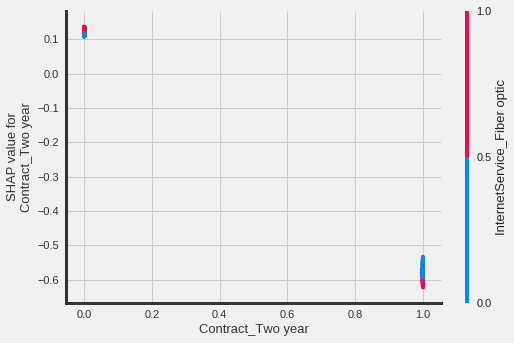

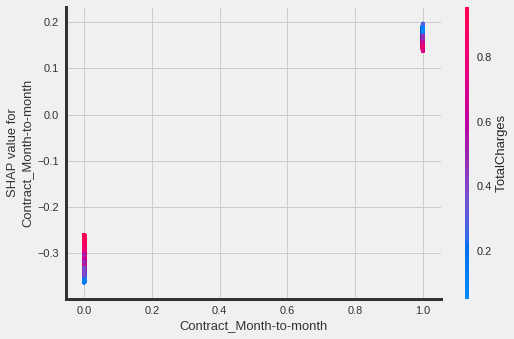

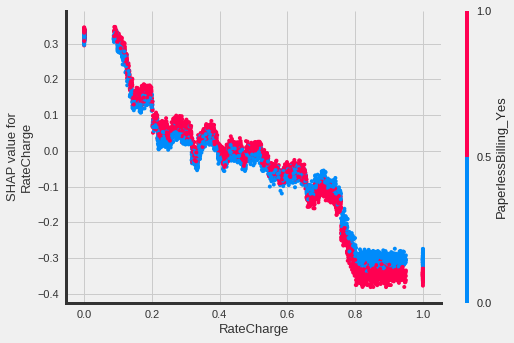

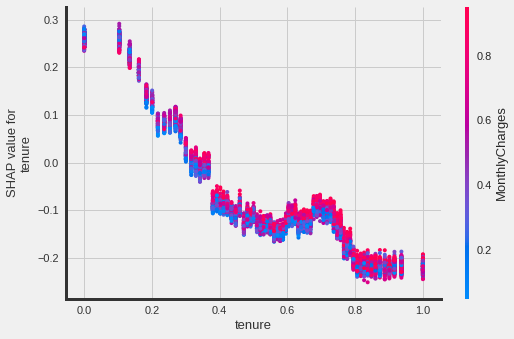

In [69]:
features = ['tenureMonthlyRate', 'Contract_Two year', 'Contract_Month-to-month', 'RateCharge', 'tenure']

for name in X_test[features]:
    shap.dependence_plot(name, shap_values[1], X)

Agrupando os dados e com a ajuda dos valores de Shapley podemos visualizar um gráfico de explicação global da saída do modelo. O objetivo do armazenamento em cluster é encontrar grupos de instâncias semelhantes. Normalmente, o armazenamento em cluster é baseado em recursos.

O cluster SHAP funciona agrupando os valores de Shapley de cada instância. Isso significa que você agrupa instâncias por semelhança de explicação. Todos os valores SHAP têm a mesma unidade - a unidade do espaço de previsão. 

O gráfico consiste em muitos gráficos de força, cada um dos quais explica a previsão de uma instância. Giramos as plotagens de força verticalmente e as colocamos lado a lado, de acordo com sua similaridade de agrupamento.

In [70]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_test.iloc[:1000,:])